### Homework 1: Futures Spread Dynamics - Hengxu Zhu 12368409

## Import Packages

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
import datetime
from statsmodels.tsa.ar_model import AutoReg 
import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [2]:
def summary_stat(data): 
    
    summary_stats = data.mean().to_frame('Mean').round(2)
    summary_stats['Volatility'] = data.std().round(2) 
    summary_stats['Sharpe Ratio'] = (summary_stats['Mean'] / summary_stats['Volatility']).round(2) 
    
    rolling_max = data.cummax()
    drawdown = data - rolling_max
    summary_stats['Max Drawdown'] = drawdown.min()
    
    summary_stats['Min'] = data.min().round(2)
    summary_stats['25% Quantile'] = data.quantile(.25, axis = 0).round(2)
    summary_stats['Median'] = data.quantile(.5, axis = 0).round(2)
    summary_stats['75% Quantile'] = data.quantile(.75, axis = 0).round(2)
    summary_stats['Max'] = data.max().round(2) 

    summary_stats['Skewness'] = data.skew().round(2)
    summary_stats['Kurtosis'] = data.kurtosis().round(2)
    
    return summary_stats

The function above calculates all the statistics that we use to analyze the future spreads. They are Mean, Volatility(Standard Deviation), Sharpe Ratio, Minimum & Maximum, 25%, 50% and 75% Tails, Max Drawdown, Skewness and Kurtosis. 

In [3]:
def rolling_stat(data, n): 
    
    data_rolling = data.rolling(n).mean()
    data = data - data_rolling
    data = data.dropna() 
    
    return summary_stat(data)

The function above calculates the difference between the rolling mean of window size N and the actual data. Then, it applies the summary_stat function on this difference. 

## Load Data

In [4]:
def fetch_quandl(my_data_items, trim_start=None, trim_end=None):
    qdata = quandl.get(list(my_data_items), returns="pandas", 
                      trim_start=trim_start, trim_end=trim_end,
                      api_key='_MNv7zC_784tGzbfxhxP')
    return qdata 

In [5]:
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

Two functions above were used by professor to fetch clean data from Quandl. 

#### From Ed Discussion, I switched from data group 9 to 8 as the professor mentioned data group 9 looks ugly.

In [6]:
headers = ['ICE_TFM_TFM_', 'NYM_NG_NG_', 'NYM_RB_RB_', 'ICE_G_G_'] 
start = "2020-12-03" 
end = "2022-08-31"  
years = ['2021', '2022'] 
months = ['H', 'M', 'U', 'Z']

def load_data(header, start, end): 
    df = pd.DataFrame()
    for i in years: 
        for j in months: 
            x = clean_quandl_columns(fetch_quandl(('OWF/' + header + j + i + '_IVM',),
                                                           trim_start=start, 
                                                           trim_end=end)) 
            df1 = x[['Future', 'DtT']]
            if len(df) == 0: 
                df = df1 
            else: 
                last = df.index[-1] + datetime.timedelta(days=1)
                df1 = df1.loc[last:]
                df1['Future'] = np.where(df1['DtT'] > 30.0, df1['Future'], np.nan) 
                df1['DtT'] = np.where(df1['DtT'] > 30.0, df1['DtT'], np.nan)
                df1 = df1.dropna()
                df = pd.concat([df, df1]) 
    return df

The function above performed the entire data loading processes. 

Firstly, by looping the expiration period from H2021 to Z2022, we download the data available from 2020-12-03 to 2022-08-31. We don't need to include any expiration in 2020 since the data after 2020-12-03 can only expire in 2021 to have a DtT > 30. 

Secondly, since the data downloaded from each loop will have overlap, we need to exclude all the overlapping data and also make sure that all data points have a DtT > 30. 

Lastly, after cleaning the data for each loop, we can just concat the new data to the data from last loop to form the entire data set. 

In [7]:
const1 = 13.7261
ice_tfm = load_data(headers[0], start, end).rename(columns={'Future': 'Future1', 'DtT': 'DtT1'})
nym_ng = load_data(headers[1], start, end).rename(columns={'Future': 'Future2', 'DtT': 'DtT2'})
ice_tfm_vs_nym_ng = ice_tfm.join(nym_ng) 
ice_tfm_vs_nym_ng['ICE vs NYM'] = ice_tfm_vs_nym_ng['Future2'] * const1 - ice_tfm_vs_nym_ng['Future1'] 

In [8]:
const2 = 0.0033
nym_rb = load_data(headers[2], start, end).rename(columns={'Future': 'Future1', 'DtT': 'DtT1'})
ice_g = load_data(headers[3], start, end).rename(columns={'Future': 'Future2', 'DtT': 'DtT2'})
nym_rb_vs_ice_g = nym_rb.join(ice_g) 
nym_rb_vs_ice_g['NYM vs ICE'] = nym_rb_vs_ice_g['Future2'] * const2 - nym_rb_vs_ice_g['Future1'] 

Calculate the future spreads according to the homework instruction. 

In [9]:
ice_tfm_vs_nym_ng = ice_tfm_vs_nym_ng.dropna() 
ice_tfm_vs_nym_ng.head()

,Future1,DtT1,Future2,DtT2,ICE vs NYM
Date,,,,,
2020-12-03,13.877,84.0,2.476,83.0,20.108824
2020-12-04,14.398,83.0,2.551,82.0,20.617281
2020-12-07,14.137,80.0,2.432,79.0,19.244875
2020-12-08,14.211,79.0,2.419,78.0,18.992436
2020-12-09,14.451,78.0,2.452,77.0,19.205397


In [10]:
nym_rb_vs_ice_g = nym_rb_vs_ice_g.dropna() 
nym_rb_vs_ice_g.head()

,Future1,DtT1,Future2,DtT2,NYM vs ICE
Date,,,,,
2020-12-03,1.2867,85.0,404.75,98.0,0.048975
2020-12-04,1.2951,84.0,406.00,97.0,0.044700
2020-12-07,1.2850,81.0,410.00,94.0,0.068000
2020-12-08,1.2851,80.0,409.75,93.0,0.067075
2020-12-09,1.2983,79.0,406.75,92.0,0.043975


#### Data Reconciliation

In [11]:
try: 
    assert(ice_tfm_vs_nym_ng.loc['2021-10-25', 'ICE vs NYM'] - (-5.751738) < 1e-6) 
    assert(ice_tfm_vs_nym_ng.loc['2021-10-28', 'ICE vs NYM'] - (-2.985990) < 1e-6) 
    assert(ice_tfm_vs_nym_ng.loc['2021-11-01', 'ICE vs NYM'] - (9.013603) < 1e-6) 
    print(True)
except: 
    print(False)

True


In [12]:
try: 
    assert(nym_rb_vs_ice_g.loc['2021-10-29', 'NYM vs ICE'] - (-0.019275) < 1e-6) 
    assert(nym_rb_vs_ice_g.loc['2021-11-01', 'NYM vs ICE'] - (0.048500) < 1e-6) 
    assert(nym_rb_vs_ice_g.loc['2021-11-10', 'NYM vs ICE'] - (0.063650) < 1e-6) 
    print(True)
except: 
    print(False)

True


Reconcile the data downloaded from Quandl to the homework instruction. 

## Analysis

The Analysis consists of 3 parts: 

1. Analyze the tails, rolling stats and autocorrelation of Data Group 0. 

2. Analyze the tails, rolling stats and autocorrelation of Data Group 8. 

3. Analyze the correlation between two Data Groups. 

#### Data Group 0 (ICE_TFM_TFM versus NYM_NG_NG ×13.7261)

Text(0.5, 1.0, 'Data Group 0 (ICE_TFM_TFM versus NYM_NG_NG ×13.7261)')

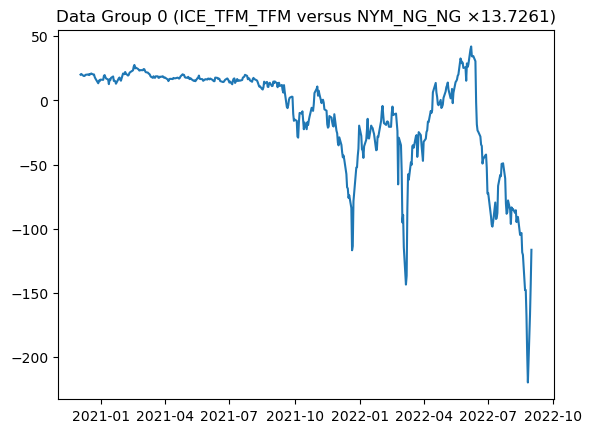

In [13]:
plt.plot(ice_tfm_vs_nym_ng['ICE vs NYM'])
plt.title('Data Group 0 (ICE_TFM_TFM versus NYM_NG_NG ×13.7261)') 

From the graph of the spread prices movement, we can see that spreads expiring during 2021 have a stable pattern while in 2022 the movement starts to become volatile. For the last month in the data, we can see a large drawdown from the graph. 

In [14]:
summary1 = summary_stat(ice_tfm_vs_nym_ng[['ICE vs NYM']]) 
summary1

,Mean,Volatility,Sharpe Ratio,Max Drawdown,Min,25% Quantile,Median,75% Quantile,Max,Skewness,Kurtosis
ICE vs NYM,-10.99,41.44,-0.27,-261.891462,-219.84,-27.48,9.61,17.14,42.05,-1.73,3.29


From the mean and the volatility, we can deduce that this spread is not worth investing as it is too volatile and we cannot even short sell it to guarantee any profit. Also, the Sharpe Ratio validates this. 

The max drawdown indicates that we might lose 26 times the mean return which is so large and indicates the volatility is high. 

Lastly, both from the quantile values and the skewness, we can tell there is a big left tail and also validates the large tail risk. In addition, the kurtosis also indicates a sharp peak compared to normal distribution. 

In [15]:
rolling_summary1 = rolling_stat(ice_tfm_vs_nym_ng[['ICE vs NYM']], 5).rename(index={'ICE vs NYM': '5-Day-Window'})
for i in [10, 15, 30]: 
    new1 = rolling_stat(ice_tfm_vs_nym_ng[['ICE vs NYM']], i).rename(index={'ICE vs NYM': str(i) + '-Day-Window'})
    rolling_summary1 = pd.concat([rolling_summary1, new1]) 
rolling_summary1

,Mean,Volatility,Sharpe Ratio,Max Drawdown,Min,25% Quantile,Median,75% Quantile,Max,Skewness,Kurtosis
5-Day-Window,-0.74,10.08,-0.07,-93.585540,-44.01,-2.50,-0.21,1.92,52.34,-0.12,7.38
10-Day-Window,-1.83,15.21,-0.12,-124.286381,-76.79,-3.71,-0.30,2.10,47.50,-1.16,5.47
15-Day-Window,-2.76,18.38,-0.15,-142.039058,-95.87,-5.32,-0.22,3.69,46.17,-1.53,5.24
30-Day-Window,-5.00,24.74,-0.20,-172.629231,-120.66,-8.93,-0.69,7.33,51.97,-1.60,3.68


As we can use similar concepts to analyze these statistics, it makes more sense to analyze these values across different rolling window(vertically). Seeing the stats vertically, we can see that with 5 days rolling window, the data behaves the best. As the rolling window becomes larger, the moving average will become smoother and it makes less effect on taking the difference between spread prices and spreading rolling average. Therefore, we can still conclude large volatility from this analysis. In specific, we will expect extreme increases and decreases. Lastly, the kurtosis also indicates a significant sharp peak. 

In [16]:
ar_model1 = AutoReg(ice_tfm_vs_nym_ng[['ICE vs NYM']], lags=1).fit()
ar_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             ICE vs NYM   No. Observations:                  450
Model:                     AutoReg(1)   Log Likelihood               -1598.006
Method:               Conditional MLE   S.D. of innovations              8.500
Date:                Thu, 12 Jan 2023   AIC                           3202.011
Time:                        13:09:39   BIC                           3214.332
Sample:                             1   HQIC                          3206.868
                                  450                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4628      0.415     -1.116      0.264      -1.275       0.350
ICE vs NYM.L1     0.9852      0.010    101.039      0.000       0.966       1.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0150           +0.0000j            1.0150            0.0000
-----------------------------------------------------------------------------
"""

The data show very strong autocorrelations of lag 1 as the beta is very significant and AIC & BIC are large. 

Time-Series model such as ARIMA(p, d, q) is suggested to be used for any forcasting. 

#### Data Group 8 (NYM_RB_RB versus ICE_G_G × 0.0033)

Text(0.5, 1.0, 'Data Group 8 (NYM_RB_RB versus ICE_G_G × 0.0033)')

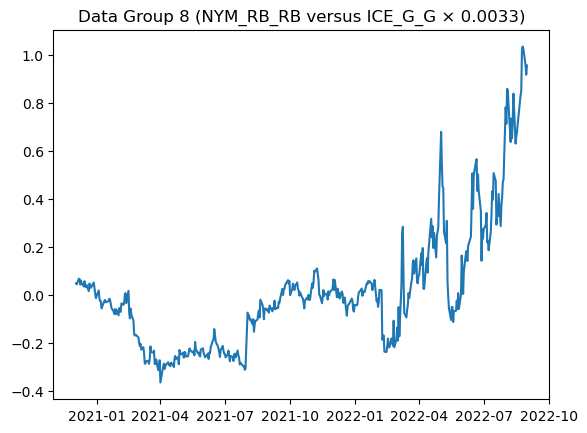

In [17]:
plt.plot(nym_rb_vs_ice_g[['NYM vs ICE']])
plt.title('Data Group 8 (NYM_RB_RB versus ICE_G_G × 0.0033)') 

Similar to Data Group 0, we can see that spreads expiring during 2021 have a relative stable pattern. During 2021-04 to 2021-07, we observe a valley. Starting from 2022, the movement starts to become volatile. From 2022-05, we can see a large jump and then move down sharply. This might creates the max drawdown. After that, the prices go up rapidly. 

In [18]:
summary2 = summary_stat(nym_rb_vs_ice_g[['NYM vs ICE']])
summary2

,Mean,Volatility,Sharpe Ratio,Max Drawdown,Min,25% Quantile,Median,75% Quantile,Max,Skewness,Kurtosis
NYM vs ICE,0.01,0.27,0.04,-0.7925,-0.36,-0.19,-0.02,0.06,1.04,1.55,2.71


From the mean and the volatility, we can deduce this spread is not worth investing as it is too volatile. The Sharpe Ratio is so small and validates this. 

The max drawdown indicates that we might lose approxiamately 80 times the mean return which is so large and indicates the volatility is high. 

Lastly, both from the quantile values and the skewness, we can tell there is a right tail and also validates the tail risk. In addition, the kurtosis also indicates a sharp peak compared to normal distribution as 2.71 is a large value in the kurtosis scale. 

In [19]:
rolling_summary2 = rolling_stat(nym_rb_vs_ice_g[['NYM vs ICE']], 5).rename(index={'NYM vs ICE': '5-Day-Window'})
for i in [10, 15, 30]: 
    new2 = rolling_stat(nym_rb_vs_ice_g[['NYM vs ICE']], i).rename(index={'NYM vs ICE': str(i) + '-Day-Window'})
    rolling_summary2 = pd.concat([rolling_summary2, new2]) 
rolling_summary2

,Mean,Volatility,Sharpe Ratio,Max Drawdown,Min,25% Quantile,Median,75% Quantile,Max,Skewness,Kurtosis
5-Day-Window,0.00,0.06,0.00,-0.533005,-0.23,-0.02,0.00,0.02,0.30,0.65,5.97
10-Day-Window,0.01,0.08,0.12,-0.722927,-0.35,-0.03,0.00,0.03,0.38,0.57,5.45
15-Day-Window,0.01,0.10,0.10,-0.791403,-0.37,-0.03,0.00,0.05,0.42,0.54,3.76
30-Day-Window,0.03,0.13,0.23,-0.824770,-0.32,-0.04,0.01,0.08,0.50,0.83,1.95


Similar to the analysis of Data Group 0, we can see the rolling window makes the data behave better. Differently, the data behaves better as the rolling window size increases. This indicates there are more small volatilities rather than extreme increases or decreases in the data. This is just comparing the Group 0. As we can see from the graph, the data is still increasing fastly. 

In [20]:
ar_model2 = AutoReg(nym_rb_vs_ice_g[['NYM vs ICE']], lags=1).fit()
ar_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             NYM vs ICE   No. Observations:                  450
Model:                     AutoReg(1)   Log Likelihood                 632.029
Method:               Conditional MLE   S.D. of innovations              0.059
Date:                Thu, 12 Jan 2023   AIC                          -1258.058
Time:                        13:09:39   BIC                          -1245.737
Sample:                             1   HQIC                         -1253.201
                                  450                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0022      0.003      0.772      0.440      -0.003       0.008
NYM vs ICE.L1     0.9888      0.011     92.670      0.000       0.968       1.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0113           +0.0000j            1.0113            0.0000
-----------------------------------------------------------------------------
"""

The data show very strong autocorrelations of lag 1 as the beta is very significant and AIC & BIC are large. 

Time-Series model such as ARIMA(p, d, q) is suggested to be used for any forcasting. 

#### Correlation

In [21]:
data_corr = ice_tfm_vs_nym_ng[['ICE vs NYM']].join(nym_rb_vs_ice_g[['NYM vs ICE']]) 
corr = data_corr.corr().round(2)
corr

,ICE vs NYM,NYM vs ICE
ICE vs NYM,1.00,-0.69
NYM vs ICE,-0.69,1.00


The data show a strong negative correlation. This indicates that there might be diversification benefits if we invest in these two spreads in long-short ways with certain calculated weights. 

## Conclusion

Two data sets have significant differences and high volatilities in 2022. We might deduce this is the recession after the Covid attack or other issues that worth investigating. For example, lots of large tech companies start layoff recently, we might be experiening a period of downside in the business cycle and people are lack of confidence of the market recently. 